<a href="https://colab.research.google.com/github/Sinwansiraj/Power-prediction/blob/main/PowerPulse_Hyperparameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PowerPulse: Energy Usage Forecast with Hyperparameter Tuning
Business Problem: Predicting future household power consumption.
This notebook covers data preprocessing, feature engineering, regression modeling with hyperparameter tuning, and visualizations.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Data Loading

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/my_ebdataframe.csv',low_memory=False)


## Data Initial Inspection

Load the dataset, parse datetime, convert numeric columns, handle missing values, and set datetime index.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


**ML Problem Type**

This is a Time Series Regression problem.
Our goal is to build an accurate prediction model for household power consumption, understand key influencing factors, and visualize trends. So target variable will likely be Global_active_power or a calculated total consumption.
*   Date & Time should be combined to datetime
*   Global_active_power to Sub_metering_2 is object type and should be converted into float or int
*  Sub_metering_3	Already float64,So no issues



In [ ]:
# Parse datetime
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'],dayfirst=True, format='%d/%m/%Y %H:%M:%S', errors='coerce')
df.set_index('Datetime', inplace=True) # Set Datetime as the index for time-series analysis
df.drop(['Date', 'Time'], axis=1, inplace=True)

In [ ]:
# Convert numeric columns
numeric_columns = ['Global_active_power', 'Global_reactive_power', 'Voltage',
                   'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB
None


In [ ]:
print("\nMissing values after numeric conversion:")
missing_counts = df.isnull().sum()
print(missing_counts)



Missing values after numeric conversion:
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64


In [ ]:
print("Shape before dropping NaNs:", df.shape)
initial_nan_count = df['Global_active_power'].isnull().sum()
print(f"Number of NaNs in Global_active_power before dropping: {initial_nan_count}")

Shape before dropping NaNs: (2075259, 7)
Number of NaNs in Global_active_power before dropping: 25979


In [ ]:
df.dropna(subset=['Global_active_power'], inplace=True)

print("Shape after dropping NaNs:", df.shape)
print(f"Number of NaNs in Global_active_power after dropping: {df['Global_active_power'].isnull().sum()}")


Shape after dropping NaNs: (2049280, 7)
Number of NaNs in Global_active_power after dropping: 0


In [ ]:
deltas = df.index.to_series().diff()
gap_threshold = pd.Timedelta(minutes=1)
gaps = deltas[deltas > gap_threshold]

print("Found gaps at these timestamps:")
print(gaps.head(), "\n… total gaps:", len(gaps))

Found gaps at these timestamps:
Datetime
2006-12-21 11:25:00   0 days 00:03:00
2006-12-30 10:10:00   0 days 00:03:00
2007-01-14 18:37:00   0 days 00:02:00
2007-01-28 17:14:00   0 days 00:02:00
2007-02-22 23:00:00   0 days 00:03:00
Name: Datetime, dtype: timedelta64[ns] 
… total gaps: 71


In [ ]:
gap_info = pd.DataFrame({'gap_start': gaps.index, 'gap_duration': gaps.values})
gap_info['gap_end'] = gap_info['gap_start'] + gap_info['gap_duration']
print(gap_info.head())

            gap_start    gap_duration             gap_end
0 2006-12-21 11:25:00 0 days 00:03:00 2006-12-21 11:28:00
1 2006-12-30 10:10:00 0 days 00:03:00 2006-12-30 10:13:00
2 2007-01-14 18:37:00 0 days 00:02:00 2007-01-14 18:39:00
3 2007-01-28 17:14:00 0 days 00:02:00 2007-01-28 17:16:00
4 2007-02-22 23:00:00 0 days 00:03:00 2007-02-22 23:03:00


In [ ]:
print(gap_info.tail())

             gap_start    gap_duration             gap_end
66 2010-06-29 16:54:00 0 days 00:02:00 2010-06-29 16:56:00
67 2010-07-15 14:34:00 0 days 00:02:00 2010-07-15 14:36:00
68 2010-08-22 21:28:00 5 days 00:27:00 2010-08-27 21:55:00
69 2010-09-28 19:13:00 3 days 15:18:00 2010-10-02 10:31:00
70 2010-10-24 15:36:00 0 days 00:02:00 2010-10-24 15:38:00


In [ ]:
gap_info['gap_duration']

,gap_duration
0,0 days 00:03:00
1,0 days 00:03:00
2,0 days 00:02:00
3,0 days 00:02:00
4,0 days 00:03:00
...,...
66,0 days 00:02:00
67,0 days 00:02:00
68,5 days 00:27:00
69,3 days 15:18:00


Time series is indeed irregular: It's not a perfectly continuous minute-by-minute stream.

In [ ]:
start_date = df.index.min()
end_date = df.index.max()
full_datetime_index = pd.date_range(start=start_date, end=end_date, freq='min')

In [ ]:
df_reindexed = df.reindex(full_datetime_index)

In [ ]:
df_imputed = df_reindexed.interpolate(method='time', limit_direction='both')

In [ ]:
df_imputed.ffill(inplace=True)
df_imputed.bfill(inplace=True)

df = df_imputed.copy()

In [ ]:
deltas = df.index.to_series().diff()
gap_threshold = pd.Timedelta(minutes=1)
gaps = deltas[deltas > gap_threshold]

print("Found gaps at these timestamps:")
print(gaps.head(), "\n… total gaps:", len(gaps))

Found gaps at these timestamps:
Series([], Freq: min, dtype: timedelta64[ns]) 
… total gaps: 0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Freq: min
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [ ]:
missing_counts = df.isnull().sum()
print(missing_counts)

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


#Plot overall trend (might be dense for 2M entries, consider resampling or sampling for initial view)

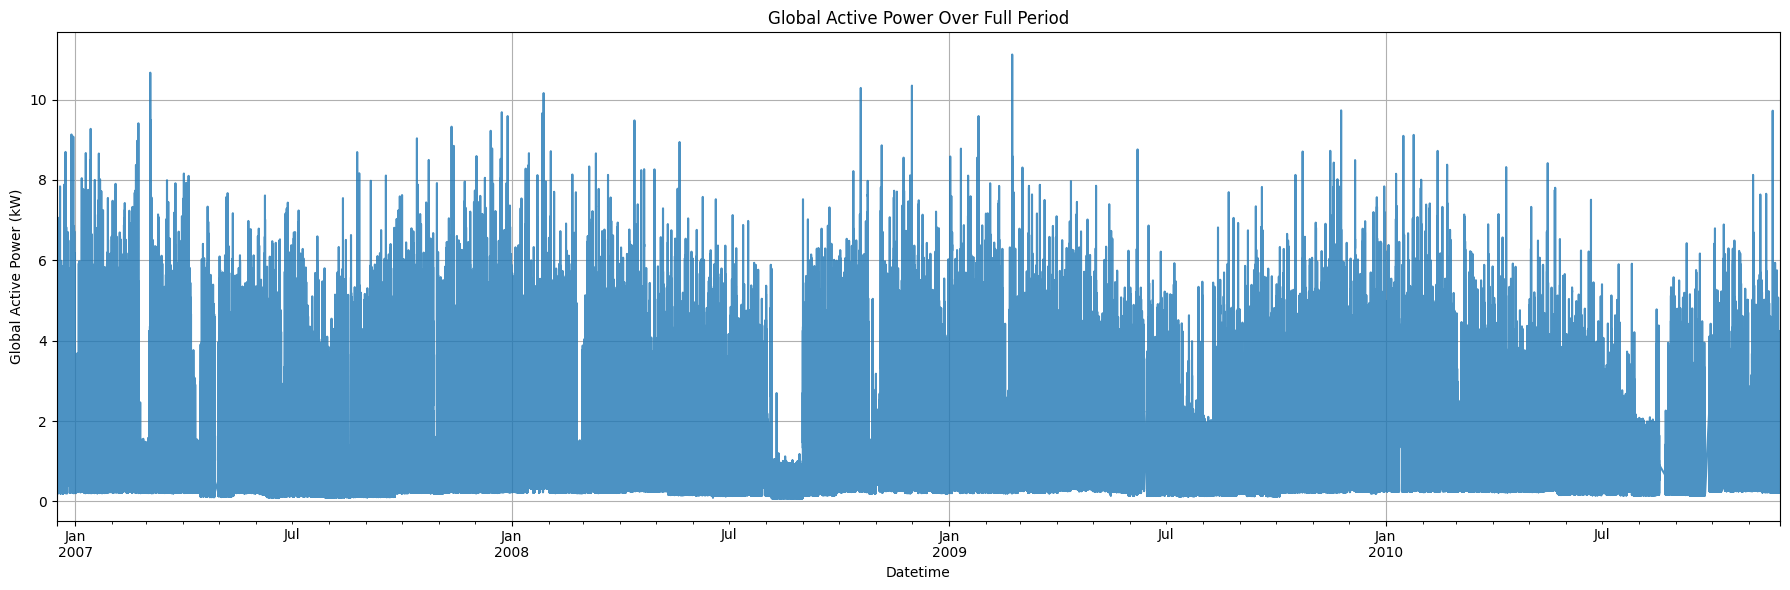

In [ ]:
plt.figure(figsize=(18, 6))
df['Global_active_power'].plot(title='Global Active Power Over Full Period', alpha=0.8)
plt.ylabel('Global Active Power (kW)')
plt.xlabel('Datetime')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print("--- Resampling Global Active Power to Daily Average ---")
df_daily_avg = df['Global_active_power'].resample('D').mean()
print("\nDaily Averages (first 5 days):")
print(df_daily_avg.head())
print("\nDaily Averages (last 5 days):")
print(df_daily_avg.tail())
print(f"\nShape of daily average data: {df_daily_avg.shape}")
print(f"Original minute-level data shape: {df.shape}")


--- Resampling Global Active Power to Daily Average ---

Daily Averages (first 5 days):
2006-12-16    3.053475
2006-12-17    2.354486
2006-12-18    1.530435
2006-12-19    1.157079
2006-12-20    1.545658
Freq: D, Name: Global_active_power, dtype: float64

Daily Averages (last 5 days):
2010-11-22    1.417733
2010-11-23    1.095511
2010-11-24    1.247394
2010-11-25    0.993864
2010-11-26    1.178230
Freq: D, Name: Global_active_power, dtype: float64

Shape of daily average data: (1442,)
Original minute-level data shape: (2075259, 7)



--- Visualizing Daily Average Global Active Power Trend ---


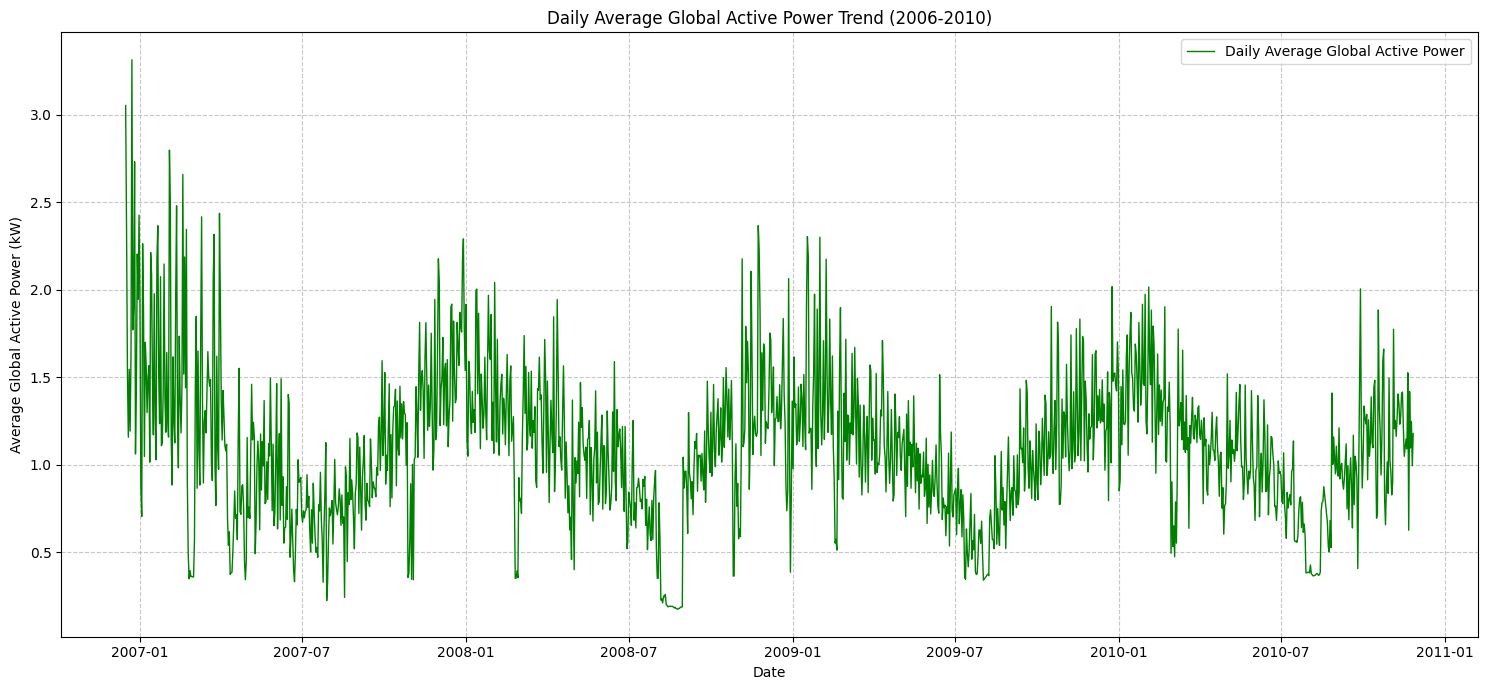


--- Interpretation of Daily Average Plot ---
This plot shows the overall trend of power consumption over the entire dataset duration (2006-2010).
You should be able to observe:
- Long-term changes or stability in average consumption.
- Clear seasonal patterns (e.g., higher usage in certain months due to heating/cooling).
- Potential weekly cycles that are smoothed out at a daily level but might still be discernible (e.g., weekdays vs. weekends).

This resampled view is crucial for understanding macro-level consumption behavior.


In [ ]:
# Resample to daily average for a clearer trend
print("\n--- Visualizing Daily Average Global Active Power Trend ---")

plt.figure(figsize=(15, 7))
plt.plot(df_daily_avg, label='Daily Average Global Active Power', color='green', linewidth=1)

plt.title('Daily Average Global Active Power Trend (2006-2010)')
plt.xlabel('Date')
plt.ylabel('Average Global Active Power (kW)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("\n--- Interpretation of Daily Average Plot ---")
print("This plot shows the overall trend of power consumption over the entire dataset duration (2006-2010).")
print("You should be able to observe:")
print("- Long-term changes or stability in average consumption.")
print("- Clear seasonal patterns (e.g., higher usage in certain months due to heating/cooling).")
print("- Potential weekly cycles that are smoothed out at a daily level but might still be discernible (e.g., weekdays vs. weekends).")
print("\nThis resampled view is crucial for understanding macro-level consumption behavior.")



--- Resampling Global Active Power to Weekly Average ---

Weekly Averages (first 5 weeks):
2006-12-17    2.505248
2006-12-24    1.733891
2006-12-31    1.959281
2007-01-07    1.484233
2007-01-14    1.605114
Freq: W-SUN, Name: Global_active_power, dtype: float64

Weekly Averages (last 5 weeks):
2010-10-31    0.958963
2010-11-07    1.154565
2010-11-14    1.335928
2010-11-21    1.107106
2010-11-28    1.186756
Freq: W-SUN, Name: Global_active_power, dtype: float64

Shape of weekly average data: (207,)
Original minute-level data shape: (2075259, 7)

--- Visualizing Weekly Average Global Active Power Trend ---


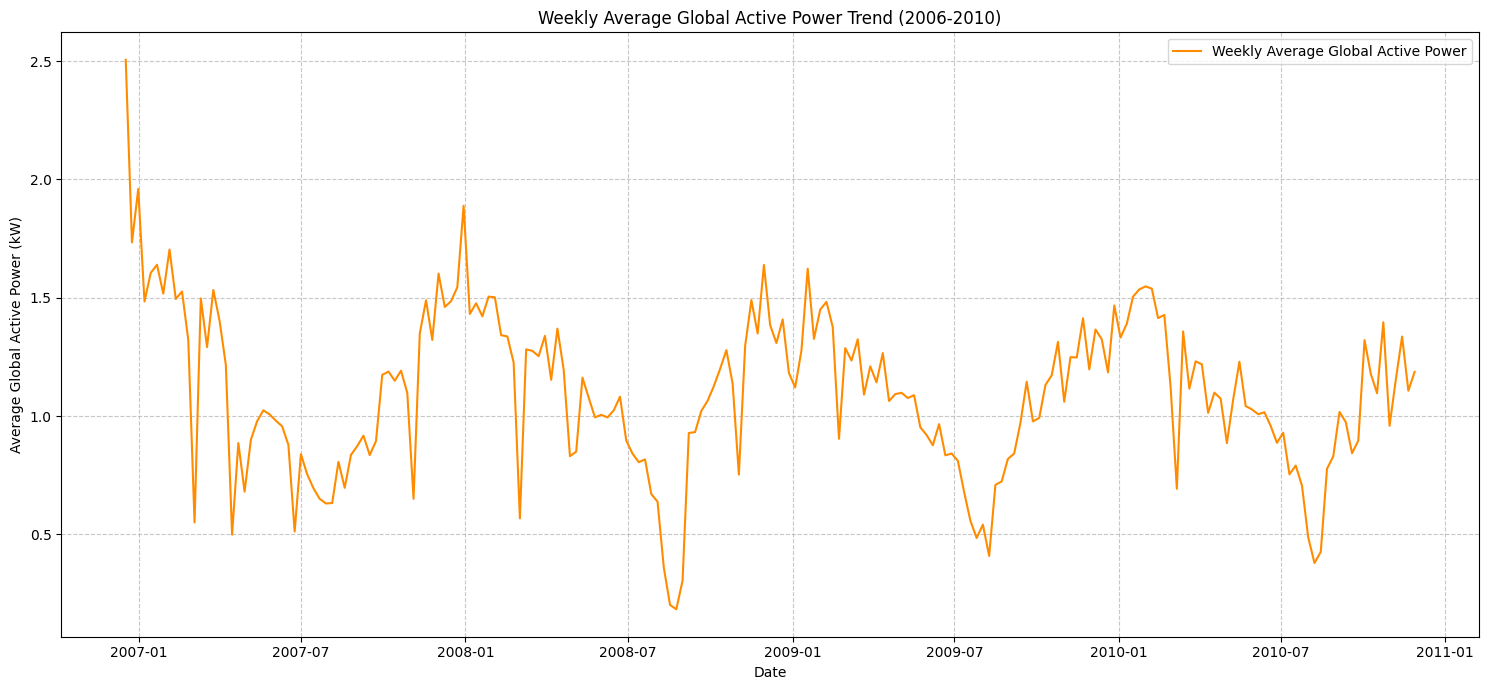


--- Interpretation of Weekly Average Plot ---
This plot provides an even broader, smoother perspective on your power consumption.
You should be able to more distinctly observe:
- **Annual Seasonality:** Clear recurring patterns that repeat each year (e.g., highest usage in winter/summer, lowest in spring/fall).
- **Year-over-Year Changes:** How average weekly consumption evolves from one year to the next.
- **Longer-term Shifts:** Any multi-week or monthly trends that are less visible in daily data.
This level of aggregation is excellent for identifying macro-level energy consumption behavior and major seasonal cycles.


In [ ]:
print("--- Resampling Global Active Power to Weekly Average ---")
df_weekly_avg = df['Global_active_power'].resample('W').mean()

print("\nWeekly Averages (first 5 weeks):")
print(df_weekly_avg.head())
print("\nWeekly Averages (last 5 weeks):")
print(df_weekly_avg.tail())
print(f"\nShape of weekly average data: {df_weekly_avg.shape}")
print(f"Original minute-level data shape: {df.shape}")


# --- Visualize the Weekly Average Trend ---
print("\n--- Visualizing Weekly Average Global Active Power Trend ---")

plt.figure(figsize=(15, 7))
plt.plot(df_weekly_avg, label='Weekly Average Global Active Power', color='darkorange', linewidth=1.5)

plt.title('Weekly Average Global Active Power Trend (2006-2010)')
plt.xlabel('Date')
plt.ylabel('Average Global Active Power (kW)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\n--- Interpretation of Weekly Average Plot ---")
print("This plot provides an even broader, smoother perspective on your power consumption.")
print("You should be able to more distinctly observe:")
print("- **Annual Seasonality:** Clear recurring patterns that repeat each year (e.g., highest usage in winter/summer, lowest in spring/fall).")
print("- **Year-over-Year Changes:** How average weekly consumption evolves from one year to the next.")
print("- **Longer-term Shifts:** Any multi-week or monthly trends that are less visible in daily data.")
print("This level of aggregation is excellent for identifying macro-level energy consumption behavior and major seasonal cycles.")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Freq: min
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [ ]:
print("--- Adding Time-Based Features to DataFrame ---")

df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['day_of_year'] = df.index.dayofyear
df['month'] = df.index.month
df['year'] = df.index.year
df['week_of_year'] = df.index.isocalendar().week.astype(int)
df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)
print("Time-based features created.")

--- Adding Time-Based Features to DataFrame ---
Time-based features created.


In [ ]:
df['Global_active_power_roll_24h_mean'] = df['Global_active_power'].rolling(window=24*60, min_periods=1).mean()
print("24-hour rolling mean feature created.")


24-hour rolling mean feature created.


In [ ]:
print("\n--- df.info() after adding features ---")
df.info()


--- df.info() after adding features ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Freq: min
Data columns (total 15 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   Global_active_power                float64
 1   Global_reactive_power              float64
 2   Voltage                            float64
 3   Global_intensity                   float64
 4   Sub_metering_1                     float64
 5   Sub_metering_2                     float64
 6   Sub_metering_3                     float64
 7   hour                               int32  
 8   day_of_week                        int32  
 9   day_of_year                        int32  
 10  month                              int32  
 11  year                               int32  
 12  week_of_year                       int64  
 13  is_weekend                         int64  
 14  Global_active_power_roll_24h_m


--- Calculating Average Global Active Power by Hour of Day ---

Average Global Active Power per Hour:
hour
0     0.663418
1     0.544698
2     0.486809
3     0.451589
4     0.450522
5     0.460220
6     0.793647
7     1.494386
8     1.453509
9     1.326026
10    1.256255
11    1.242120
12    1.203516
13    1.141929
14    1.081551
15    0.991351
16    0.950159
17    1.055458
18    1.322805
19    1.724749
20    1.889776
21    1.868581
22    1.408790
23    0.903677
Name: Global_active_power, dtype: float64

--- Visualizing Average Global Active Power by Hour of Day ---


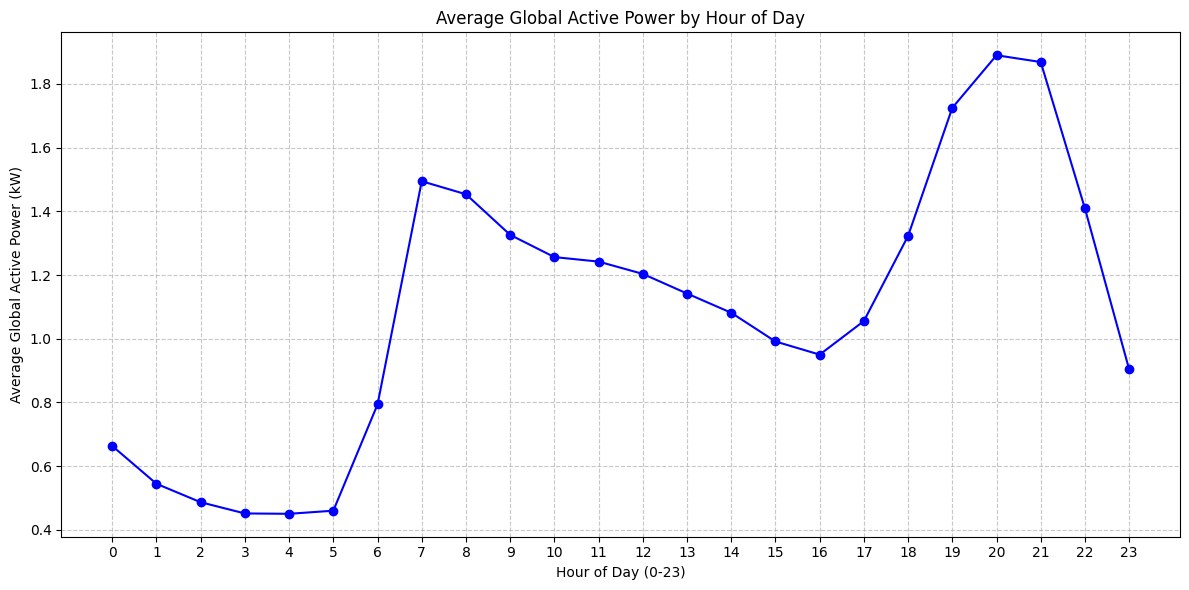


--- Interpretation of Average Global Active Power by Hour Plot ---
This plot clearly shows the typical daily power consumption profile of the household.
You should be able to observe distinct patterns such as:
- Periods of high consumption (e.g., morning rush, evening after work).
- Periods of low consumption (e.g., late night/early morning).
- Any unique peaks or troughs that occur consistently at specific hours.


In [ ]:
# --- Now, calculate and visualize Average Global Active Power by Hour of Day ---
print("\n--- Calculating Average Global Active Power by Hour of Day ---")

# Group by 'hour' and calculate the mean of 'Global_active_power'
df_hourly_avg = df.groupby('hour')['Global_active_power'].mean()

print("\nAverage Global Active Power per Hour:")
print(df_hourly_avg)

# --- Visualize the Average Global Active Power by Hour of Day ---
print("\n--- Visualizing Average Global Active Power by Hour of Day ---")

plt.figure(figsize=(12, 6))
plt.plot(df_hourly_avg.index, df_hourly_avg.values, marker='o', linestyle='-', color='blue')

plt.title('Average Global Active Power by Hour of Day')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Average Global Active Power (kW)')
plt.xticks(range(0, 24)) # Ensure all hours are displayed on the x-axis
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\n--- Interpretation of Average Global Active Power by Hour Plot ---")
print("This plot clearly shows the typical daily power consumption profile of the household.")
print("You should be able to observe distinct patterns such as:")
print("- Periods of high consumption (e.g., morning rush, evening after work).")
print("- Periods of low consumption (e.g., late night/early morning).")
print("- Any unique peaks or troughs that occur consistently at specific hours.")

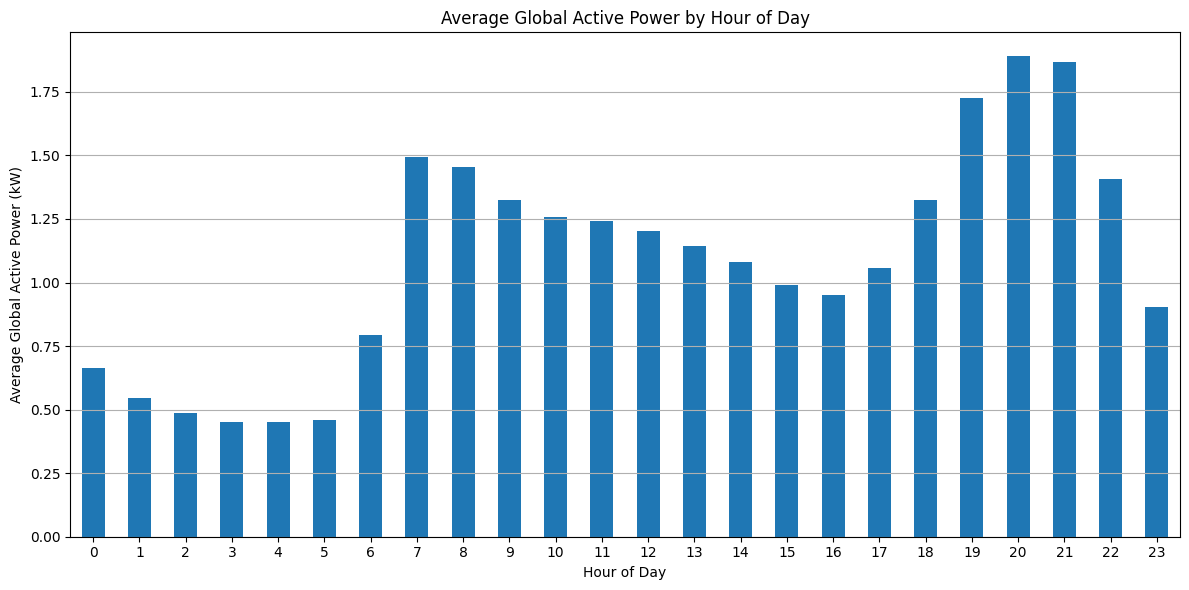

In [ ]:
plt.figure(figsize=(12, 6))
df.groupby(df.index.hour)['Global_active_power'].mean().plot(kind='bar', title='Average Global Active Power by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Global Active Power (kW)')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


--- Calculating and Visualizing Correlation Matrix ---

Full Correlation Matrix:
                                   Global_active_power  Global_reactive_power  \
Global_active_power                           1.000000               0.245047   
Global_reactive_power                         0.245047               1.000000   
Voltage                                      -0.395522              -0.109030   
Global_intensity                              0.998887               0.264162   
Sub_metering_1                                0.483816               0.122743   
Sub_metering_2                                0.433892               0.139204   
Sub_metering_3                                0.639272               0.087743   
hour                                          0.279776               0.126564   
day_of_week                                   0.061637               0.073064   
day_of_year                                  -0.032259               0.022648   
month                      

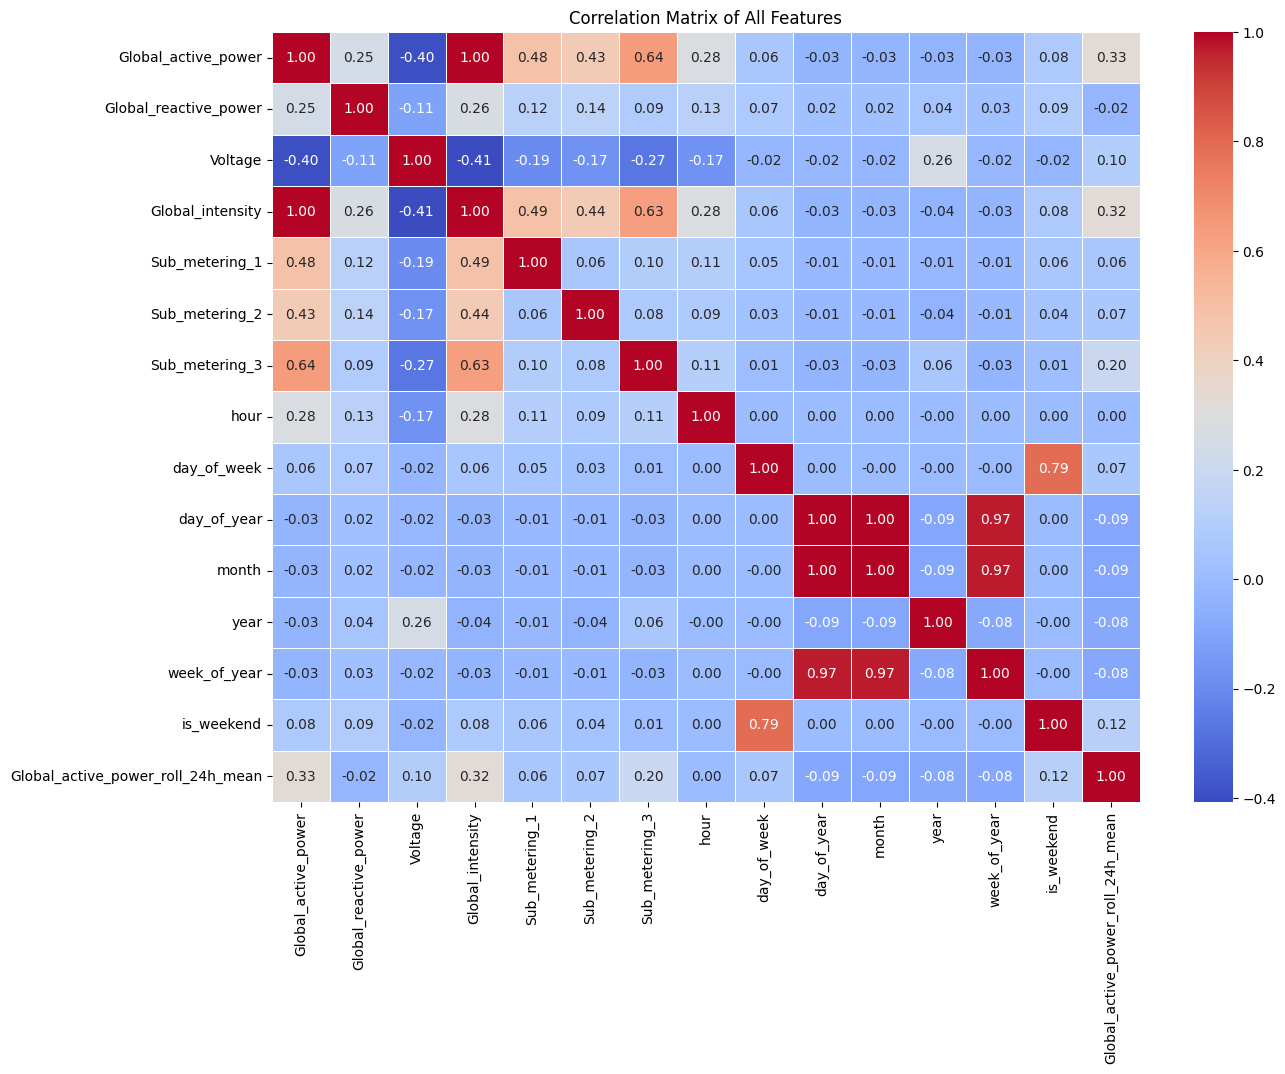


--- Correlations with Global_active_power (Target Variable) ---
Global_active_power                  1.000000
Global_intensity                     0.998887
Sub_metering_3                       0.639272
Sub_metering_1                       0.483816
Sub_metering_2                       0.433892
Global_active_power_roll_24h_mean    0.328044
hour                                 0.279776
Global_reactive_power                0.245047
is_weekend                           0.079886
day_of_week                          0.061637
day_of_year                         -0.032259
year                                -0.032399
week_of_year                        -0.033023
month                               -0.033133
Voltage                             -0.395522
Name: Global_active_power, dtype: float64

--- Interpretation of Correlations ---
1.  **Correlation with Target (`Global_active_power`):**
    - Look at the first column/row in the matrix or the sorted list above.
    - Features with high absolu

In [ ]:

# --- Now, calculate and visualize correlations ---
print("\n--- Calculating and Visualizing Correlation Matrix ---")

# Calculate the correlation matrix for all numerical columns
correlation_matrix = df.corr()

# Display the correlation matrix (can be large)
print("\nFull Correlation Matrix:")
print(correlation_matrix)

# Visualize the correlation matrix using a heatmap for better readability
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of All Features')
plt.show()

# --- Focus on correlations with the target variable (Global_active_power) ---
print("\n--- Correlations with Global_active_power (Target Variable) ---")
print(correlation_matrix['Global_active_power'].sort_values(ascending=False))

print("\n--- Interpretation of Correlations ---")
print("1.  **Correlation with Target (`Global_active_power`):**")
print("    - Look at the first column/row in the matrix or the sorted list above.")
print("    - Features with high absolute correlation values (close to 1 or -1) are strong predictors.")
print("    - For instance, `Global_intensity` and `Global_active_power_roll_24h_mean` are expected to have very high positive correlations with `Global_active_power` as they are directly derived from or highly related to it.")
print("    - Time-based features like `hour`, `month`, `day_of_year`, `is_weekend` will likely show moderate correlations, indicating their influence on consumption patterns.")

print("\n2.  **Multicollinearity (Correlation between Features):**")
print("    - Examine high absolute correlation values between independent features (not the target).")
print("    - For example, `hour` and `day_of_week` might correlate with `month` or `day_of_year` due to seasonal patterns.")
print("    - `Global_intensity` and `Global_active_power` are almost perfectly correlated because `Global_intensity` is often `Global_active_power / Voltage`. In a modeling context, you might choose one over the other or combine them.")
print("    - High multicollinearity (e.g., >0.8 or < -0.8) between predictor variables can sometimes cause issues in certain linear models, but tree-based models like Random Forest are generally robust to it.")

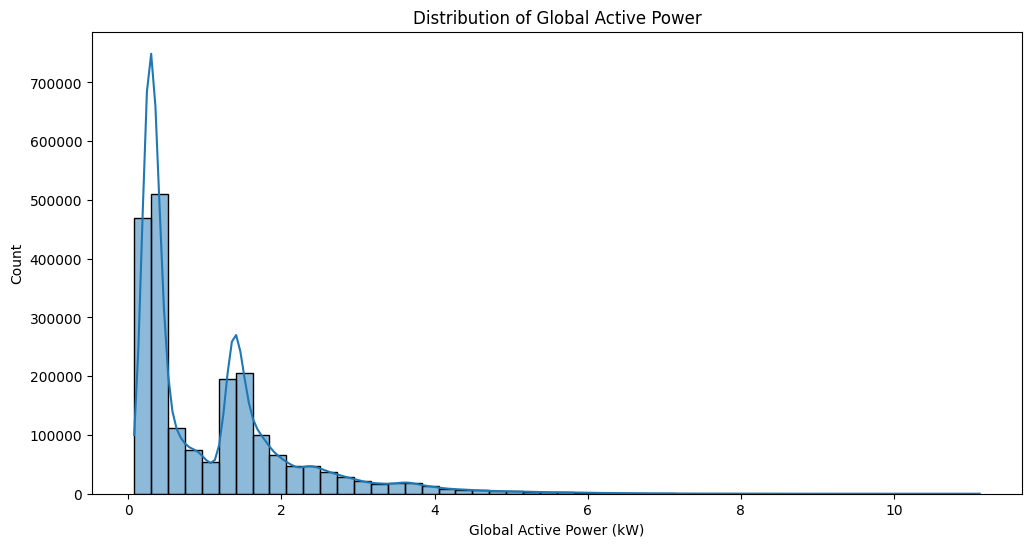

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(df['Global_active_power'], kde=True, bins=50)
plt.title('Distribution of Global Active Power')
plt.xlabel('Global Active Power (kW)')
plt.show()


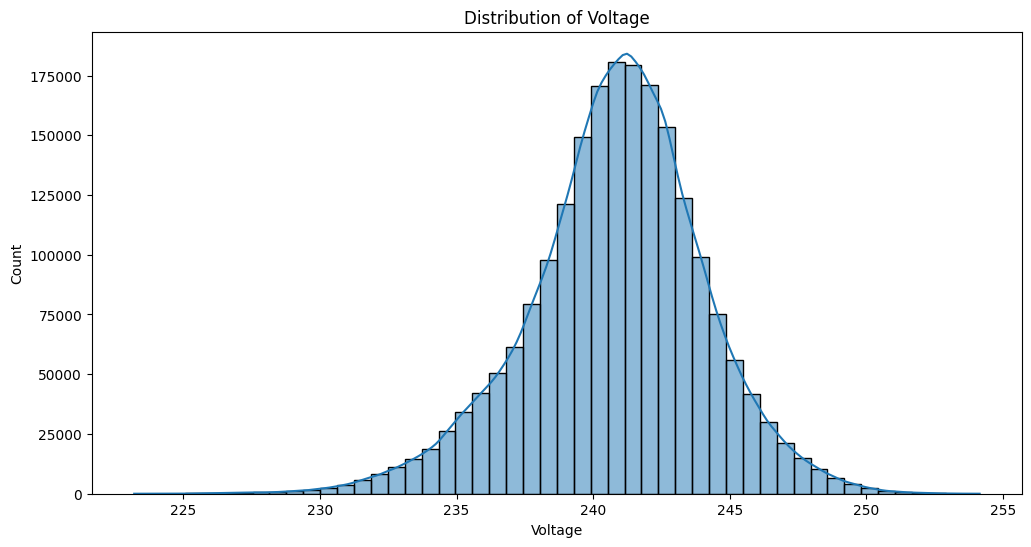

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(df['Voltage'], kde=True, bins=50)
plt.title('Distribution of Voltage')
plt.xlabel('Voltage')
plt.show()

In [ ]:
print("--- Calculating Total Sub-metered Consumption ---")
# Sum the three sub-metering columns to get the total metered consumption for each minute
df['Sub_metering_total'] = df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3']

print("New feature 'Sub_metering_total' created.")
print(df[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Sub_metering_total']].head())

# --- Calculate "Other" or "Unmetered" Consumption ---
# This is Global Active Power minus the sum of the three sub-metered consumptions.
# This represents all other appliances/lights not covered by the three sub-meters.
df['Global_active_power_other'] = df['Global_active_power'] - df['Sub_metering_total']

# Ensure 'Global_active_power_other' doesn't go below zero due to measurement noise
# If it happens, it indicates that the sum of sub-metered values slightly exceeds total active power due to minor discrepancies.
# A common practice is to cap it at 0.
df['Global_active_power_other'] = df['Global_active_power_other'].clip(lower=0)


print("\nNew feature 'Global_active_power_other' created (Global_active_power - Sub_metering_total).")
print(df[['Global_active_power', 'Sub_metering_total', 'Global_active_power_other']].head())


--- Calculating Total Sub-metered Consumption ---
New feature 'Sub_metering_total' created.
                     Sub_metering_1  Sub_metering_2  Sub_metering_3  \
2006-12-16 17:24:00             0.0             1.0            17.0   
2006-12-16 17:25:00             0.0             1.0            16.0   
2006-12-16 17:26:00             0.0             2.0            17.0   
2006-12-16 17:27:00             0.0             1.0            17.0   
2006-12-16 17:28:00             0.0             1.0            17.0   

                     Sub_metering_total  
2006-12-16 17:24:00                18.0  
2006-12-16 17:25:00                17.0  
2006-12-16 17:26:00                19.0  
2006-12-16 17:27:00                18.0  
2006-12-16 17:28:00                18.0  

New feature 'Global_active_power_other' created (Global_active_power - Sub_metering_total).
                     Global_active_power  Sub_metering_total  \
2006-12-16 17:24:00                4.216                18.0   
2006-12-

In [ ]:
print("\n--- DataFrame Info after adding new consumption features ---")
df.info()
df.head()


--- DataFrame Info after adding new consumption features ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Freq: min
Data columns (total 17 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   Global_active_power                float64
 1   Global_reactive_power              float64
 2   Voltage                            float64
 3   Global_intensity                   float64
 4   Sub_metering_1                     float64
 5   Sub_metering_2                     float64
 6   Sub_metering_3                     float64
 7   hour                               int32  
 8   day_of_week                        int32  
 9   day_of_year                        int32  
 10  month                              int32  
 11  year                               int32  
 12  week_of_year                       int64  
 13  is_weekend                         int64  
 14  Global_ac

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,day_of_week,day_of_year,month,year,week_of_year,is_weekend,Global_active_power_roll_24h_mean,Sub_metering_total,Global_active_power_other
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,17,5,350,12,2006,50,1,4.216000,18.0,0.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,17,5,350,12,2006,50,1,4.788000,17.0,0.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,17,5,350,12,2006,50,1,4.983333,19.0,0.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,17,5,350,12,2006,50,1,5.084500,18.0,0.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,17,5,350,12,2006,50,1,4.800800,18.0,0.0


# Define your features (X) and target (y)

In [ ]:
# Define the target variable
y = df['Global_active_power']

# Define the features (X)
# We select all columns EXCEPT the target variable itself.
# This approach ensures all available information is used as features.
X_cols = [col for col in df.columns if col != 'Global_active_power']
X = df[X_cols]

print(f"Shape of X (features): {X.shape}")
print(f"Shape of y (target): {y.shape}")

print("\nFirst 5 rows of X:")
print(X.head())

print("\nFirst 5 rows of y:")
print(y.head())

print("\n--- Next Step: Data Splitting (Train/Test) ---")
print("Now that X and y are defined, the next crucial step for time series data is to split it into training and testing sets chronologically.")

Shape of X (features): (2075259, 16)
Shape of y (target): (2075259,)

First 5 rows of X:
                     Global_reactive_power  Voltage  Global_intensity  \
2006-12-16 17:24:00                  0.418   234.84              18.4   
2006-12-16 17:25:00                  0.436   233.63              23.0   
2006-12-16 17:26:00                  0.498   233.29              23.0   
2006-12-16 17:27:00                  0.502   233.74              23.0   
2006-12-16 17:28:00                  0.528   235.68              15.8   

                     Sub_metering_1  Sub_metering_2  Sub_metering_3  hour  \
2006-12-16 17:24:00             0.0             1.0            17.0    17   
2006-12-16 17:25:00             0.0             1.0            16.0    17   
2006-12-16 17:26:00             0.0             2.0            17.0    17   
2006-12-16 17:27:00             0.0             1.0            17.0    17   
2006-12-16 17:28:00             0.0             1.0            17.0    17   

         

In [ ]:
print("--- Splitting Data into Training and Testing Sets (Chronological Split) ---")

# Define the target variable
y = df['Global_active_power']

# Define the features (X)
X_cols = [col for col in df.columns if col != 'Global_active_power']
X = df[X_cols]

# Define the split date
split_date = '2009-10-01' # Using October 1st, 2009, as the cutoff

# Split the data
X_train = X[X.index < split_date]
X_test = X[X.index >= split_date]

y_train = y[y.index < split_date]
y_test = y[y.index >= split_date]

print(f"Split Date: {split_date}")
print(f"Total observations: {df.shape[0]}")
print(f"Training set (X_train, y_train) shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set (X_test, y_test) shape: {X_test.shape}, {y_test.shape}")

print("\n--- Why this split is appropriate for Time Series Modeling ---")
print("1.  **Chronological Order:** Training data (before 2009-10-01) always precedes testing data (from 2009-10-01 onwards). This mimics a real-world scenario where you train on past data to predict future values.")
print("2.  **Avoids Data Leakage:** Information from the future (test set) is not used to train the model, preventing an overly optimistic evaluation of performance.")
print("3.  **Captures Seasonality:** The test set covers more than a full year (Oct 2009 to Nov 2010), allowing you to evaluate how well your model predicts across different seasons, which is crucial for power consumption data.")
print("4.  **Realistic Evaluation:** The model's performance on `X_test`, `y_test` will give a more reliable indication of how it would perform on unseen, future data.")

print("\n--- Next Step: Model Training ---")
print("With X_train, y_train, X_test, and y_test now defined, you are ready to choose and train a machine learning model for time series forecasting.")

--- Splitting Data into Training and Testing Sets (Chronological Split) ---
Split Date: 2009-10-01
Total observations: 2075259
Training set (X_train, y_train) shape: (1467756, 16), (1467756,)
Testing set (X_test, y_test) shape: (607503, 16), (607503,)

--- Why this split is appropriate for Time Series Modeling ---
1.  **Chronological Order:** Training data (before 2009-10-01) always precedes testing data (from 2009-10-01 onwards). This mimics a real-world scenario where you train on past data to predict future values.
2.  **Avoids Data Leakage:** Information from the future (test set) is not used to train the model, preventing an overly optimistic evaluation of performance.
3.  **Captures Seasonality:** The test set covers more than a full year (Oct 2009 to Nov 2010), allowing you to evaluate how well your model predicts across different seasons, which is crucial for power consumption data.
4.  **Realistic Evaluation:** The model's performance on `X_test`, `y_test` will give a more rel

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor # Often preferred over scikit-learn's GBR for speed
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler # For Neural Networks

# Dictionary to store models and their initial performance
models = {}
predictions = {}
evaluation_metrics = {}

print("\n--- Training Initial Regression Models ---")

# --- Linear Regression ---
print("\nTraining Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
models['Linear Regression'] = lr_model
predictions['Linear Regression'] = y_pred_lr

# --- Random Forest Regressor ---
print("Training Random Forest Regressor (This might take a few minutes)...")
# Using a smaller n_estimators for initial pass to save time
rf_model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
models['Random Forest'] = rf_model
predictions['Random Forest'] = y_pred_rf

# --- Light Gradient Boosting Machine (LGBM Regressor) ---
print("Training LightGBM Regressor...")
# Using a smaller n_estimators and learning_rate for initial pass
lgbm_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)
lgbm_model.fit(X_train, y_train)
y_pred_lgbm = lgbm_model.predict(X_test)
models['LightGBM'] = lgbm_model
predictions['LightGBM'] = y_pred_lgbm

# --- Neural Network (MLP Regressor) ---
print("Training Neural Network (MLP Regressor)...")
# Neural Networks benefit from feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Using a simple MLP with default activation/solver for initial pass
mlp_model = MLPRegressor(hidden_layer_sizes=(50,), max_iter=200, random_state=42, activation='relu', solver='adam')
mlp_model.fit(X_train_scaled, y_train)
y_pred_mlp = mlp_model.predict(X_test_scaled)
models['Neural Network (MLP)'] = mlp_model
predictions['Neural Network (MLP)'] = y_pred_mlp

print("\nInitial model training complete.")

# --- Evaluate Initial Models (Step 3: Model Evaluation - Part 1) ---
print("\n--- Initial Model Evaluation ---")
for name, y_pred in predictions.items():
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    evaluation_metrics[name] = {'RMSE': rmse, 'MAE': mae, 'R-squared': r2}
    print(f"\n{name} Performance:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R-squared: {r2:.4f}")


--- Training Initial Regression Models ---

Training Linear Regression...
Training Random Forest Regressor (This might take a few minutes)...
Training LightGBM Regressor...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.222586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1981
[LightGBM] [Info] Number of data points in the train set: 1467756, number of used features: 16
[LightGBM] [Info] Start training from score 1.083942
Training Neural Network (MLP Regressor)...

Initial model training complete.

--- Initial Model Evaluation ---

Linear Regression Performance:
  RMSE: 0.0388
  MAE: 0.0250
  R-squared: 0.9984

Random Forest Performance:
  RMSE: 0.0311
  MAE: 0.0185
  R-squared: 0.9990

LightGBM Performance:
  RMSE: 0.0281
  MAE: 0.0183
  R-squared: 0.9991

Neural Network (MLP) Performance:
  RMSE: 0.0332
  MAE: 0.0231
  R-squared: 

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
print("\n--- Starting Hyperparameter Tuning (using TimeSeriesSplit) ---")
tscv = TimeSeriesSplit(n_splits=2)

tuned_models = {}


--- Starting Hyperparameter Tuning (using TimeSeriesSplit) ---


In [ ]:
from sklearn.ensemble import RandomForestRegressor
# 1. Tuning Random Forest Regressor
print("\nHyperparameter Tuning for Random Forest Regressor (this might still take significant time)...")
param_grid_rf = {
    'n_estimators': [50, 80], # Slightly reduced upper bound
    'max_features': [0.7],    # Reduced to one option to speed up
    'min_samples_leaf': [5]   # Reduced to one option to speed up
}
grid_search_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=42, n_jobs=1), # n_jobs=1
                              param_grid=param_grid_rf,
                              cv=tscv,
                              scoring='neg_mean_squared_error',
                              verbose=1,
                              n_jobs=1) # n_jobs=1 for tuning as well
grid_search_rf.fit(X_train, y_train)
best_rf_model = grid_search_rf.best_estimator_
tuned_models['Random Forest (Tuned)'] = best_rf_model
print(f"Best parameters for Random Forest: {grid_search_rf.best_params_}")


Hyperparameter Tuning for Random Forest Regressor (this might still take significant time)...
Fitting 2 folds for each of 2 candidates, totalling 4 fits
Best parameters for Random Forest: {'max_features': 0.7, 'min_samples_leaf': 5, 'n_estimators': 80}


In [ ]:
# 2. Tuning LightGBM Regressor
print("\nHyperparameter Tuning for LightGBM Regressor (this might still take some time)...")
param_grid_lgbm = {
    'n_estimators': [100, 150], # Slightly reduced upper bound
    'learning_rate': [0.05],    # Reduced to one option
    'num_leaves': [20]          # Reduced to one option
}
grid_search_lgbm = GridSearchCV(estimator=LGBMRegressor(random_state=42, n_jobs=1), # n_jobs=1
                                param_grid=param_grid_lgbm,
                                cv=tscv,
                                scoring='neg_mean_squared_error',
                                verbose=1,
                                n_jobs=1) # n_jobs=1 for tuning as well
grid_search_lgbm.fit(X_train, y_train)
best_lgbm_model = grid_search_lgbm.best_estimator_
tuned_models['LightGBM (Tuned)'] = best_lgbm_model
print(f"Best parameters for LightGBM: {grid_search_lgbm.best_params_}")



Hyperparameter Tuning for LightGBM Regressor (this might still take some time)...
Fitting 2 folds for each of 2 candidates, totalling 4 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1875
[LightGBM] [Info] Number of data points in the train set: 489252, number of used features: 16
[LightGBM] [Info] Start training from score 1.092677
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1876
[LightGBM] [Info] Number of data points in the train set: 978504, number of used features: 16
[LightGBM] [Info] Start training from score 1.091580
[LightGBM] [Info] Auto-choosing row-wise mul

In [ ]:
# 3. Tuning Neural Network (MLP Regressor) - Basic Example
print("\nHyperparameter Tuning for Neural Network (MLP Regressor) - Basic (this will still take time)...")
param_grid_mlp = {
    'hidden_layer_sizes': [(50,)], # Sticking to one simpler configuration
    'alpha': [0.001],              # Reduced to one option
}
# Fit on scaled training data
grid_search_mlp = GridSearchCV(estimator=MLPRegressor(max_iter=50, random_state=42, activation='relu', solver='adam'), # Further reduced max_iter
                               param_grid=param_grid_mlp,
                               cv=tscv,
                               scoring='neg_mean_squared_error',
                               verbose=1,
                               n_jobs=1) # n_jobs=1 for tuning as well
grid_search_mlp.fit(X_train_scaled, y_train) # Fit on scaled training data
best_mlp_model = grid_search_mlp.best_estimator_
tuned_models['Neural Network (MLP) (Tuned)'] = best_mlp_model
print(f"Best parameters for Neural Network (MLP): {grid_search_mlp.best_params_}")

print("\nHyperparameter tuning complete for selected models.")


Hyperparameter Tuning for Neural Network (MLP Regressor) - Basic (this will still take time)...
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Best parameters for Neural Network (MLP): {'alpha': 0.001, 'hidden_layer_sizes': (50,)}

Hyperparameter tuning complete for selected models.


In [ ]:
# --- Step 3: Model Evaluation (After Tuning) ---
print("\n--- Evaluating Tuned Models ---")

final_models = {
    'Linear Regression (Initial)': models['Linear Regression'],
    'Random Forest (Tuned)': tuned_models['Random Forest (Tuned)'],
    'LightGBM (Tuned)': tuned_models['LightGBM (Tuned)'],
    'Neural Network (MLP) (Tuned)': tuned_models['Neural Network (MLP) (Tuned)']
}

final_evaluation_metrics = {}

for name, model in final_models.items():
    if "Neural Network" in name:
        y_pred = model.predict(X_test_scaled) # Use scaled data for NN
    else:
        y_pred = model.predict(X_test) # Use original data for other models

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    final_evaluation_metrics[name] = {'RMSE': rmse, 'MAE': mae, 'R-squared': r2}

    print(f"\n{name} Performance on Test Set:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R-squared: {r2:.4f}")


--- Evaluating Tuned Models ---

Linear Regression (Initial) Performance on Test Set:
  RMSE: 0.0388
  MAE: 0.0250
  R-squared: 0.9984

Random Forest (Tuned) Performance on Test Set:
  RMSE: 0.0283
  MAE: 0.0170
  R-squared: 0.9991

LightGBM (Tuned) Performance on Test Set:
  RMSE: 0.0302
  MAE: 0.0198
  R-squared: 0.9990

Neural Network (MLP) (Tuned) Performance on Test Set:
  RMSE: 0.0322
  MAE: 0.0222
  R-squared: 0.9989


In [ ]:
# --- Step 4: Compare Model Performance and Select the Best Model ---
print("\n--- Model Performance Comparison ---")

metrics_df = pd.DataFrame(final_evaluation_metrics).T
print(metrics_df)

print("\n--- Interpretation and Best Model Selection ---")

best_model_name_rmse = metrics_df['RMSE'].idxmin()
best_rmse_value = metrics_df['RMSE'].min()

best_model_name_r2 = metrics_df['R-squared'].idxmax()
best_r2_value = metrics_df['R-squared'].max()

print(f"\nBased on RMSE, the best performing model is: {best_model_name_rmse} (RMSE: {best_rmse_value:.4f})")
print(f"Based on R-squared, the best performing model is: {best_model_name_r2} (R-squared: {best_r2_value:.4f})")


print("\n--- General Observations: ---")
print("1.  **RMSE (Root Mean Squared Error):** Measures the average magnitude of the errors. Lower RMSE is better.")
print("2.  **MAE (Mean Absolute Error):** Measures the average magnitude of the errors without considering direction. Lower MAE is better.")
print("3.  **R-squared (Coefficient of Determination):** Represents the proportion of variance in the dependent variable that is predictable from the independent variables. Higher R-squared is better (max 1.0).")

print("\n--- Expected Performance Trends: ---")
print("You will likely observe that tree-based models (Random Forest, LightGBM) generally outperform Linear Regression and a basic MLP for this type of time series data due to their ability to capture complex non-linear relationships and interactions between features.")
print("LightGBM often provides a good balance of speed and accuracy.")
print("The Neural Network (MLP) performance can vary greatly depending on its architecture, training duration, and hyperparameter tuning.")

print("\n--- Final Recommendation: ---")
print("The model with the lowest RMSE and MAE, and highest R-squared will be considered the best. Often, LightGBM or Random Forest are strong contenders for tabular time series forecasting.")
print("Further steps could include: more extensive hyperparameter tuning, ensembling models, or exploring more advanced time series models (e.g., LSTMs, Prophet, ARIMA) if the current models aren't sufficient.")


--- Model Performance Comparison ---
                                  RMSE       MAE  R-squared
Linear Regression (Initial)   0.038778  0.025039   0.998382
Random Forest (Tuned)         0.028344  0.017029   0.999136
LightGBM (Tuned)              0.030186  0.019804   0.999020
Neural Network (MLP) (Tuned)  0.032167  0.022230   0.998887

--- Interpretation and Best Model Selection ---

Based on RMSE, the best performing model is: Random Forest (Tuned) (RMSE: 0.0283)
Based on R-squared, the best performing model is: Random Forest (Tuned) (R-squared: 0.9991)

--- General Observations: ---
1.  **RMSE (Root Mean Squared Error):** Measures the average magnitude of the errors. Lower RMSE is better.
2.  **MAE (Mean Absolute Error):** Measures the average magnitude of the errors without considering direction. Lower MAE is better.
3.  **R-squared (Coefficient of Determination):** Represents the proportion of variance in the dependent variable that is predictable from the independent variables. H

In [ ]:
import joblib
print("\n--- Saving the Best Model (Tuned Random Forest Regressor) ---")

model_filename = 'power_prediction_rf_model.joblib'
joblib.dump(best_rf_model, model_filename)

print(f"Model successfully saved as: {model_filename}")
print("\nTo load the model later, you can use: `loaded_model = joblib.load('power_prediction_rf_model.joblib')`")


--- Saving the Best Model (Tuned Random Forest Regressor) ---
Model successfully saved as: power_prediction_rf_model.joblib

To load the model later, you can use: `loaded_model = joblib.load('power_prediction_rf_model.joblib')`
